# Sparse inversion of gravity

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import discretize
import simpeg
from simpeg import potential_fields

from utilities import plot_model, plot_block, get_latest_model_files

# Load data

In [2]:
df = pd.read_csv("gravity.csv", index_col=None)
df

,easting,northing,upward,gz,gz_std
0,-2000.0,-2000.0,10.0,-0.003058,0.002853
1,-1900.0,-2000.0,10.0,-0.007185,0.002853
2,-1800.0,-2000.0,10.0,-0.002388,0.002853
3,-1700.0,-2000.0,10.0,-0.002177,0.002853
4,-1600.0,-2000.0,10.0,-0.010777,0.002853
...,...,...,...,...,...
1676,1600.0,2000.0,10.0,-0.002390,0.002853
1677,1700.0,2000.0,10.0,-0.003820,0.002853
1678,1800.0,2000.0,10.0,-0.006600,0.002853
1679,1900.0,2000.0,10.0,-0.005018,0.002853


In [3]:
shape = (41, 41)
assert shape[0] * shape[1] == df.easting.size

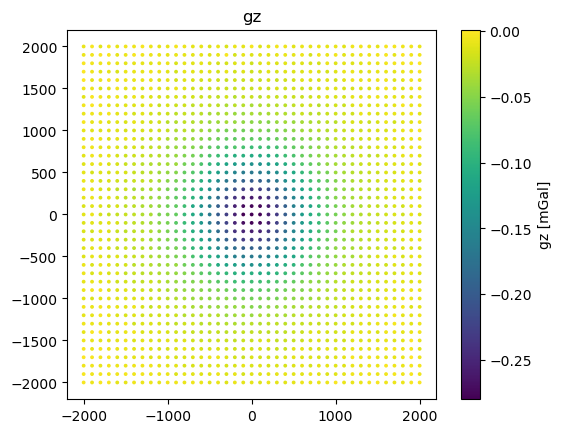

In [4]:
plt.scatter(
    df.easting,
    df.northing,
    c=df.gz,
    s=3,
    cmap="viridis",
)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz [mGal]")
plt.title("gz")
plt.show()

## Build mesh

Thumb rules for mesh design:
* Horizontal cell size: around half the size of the spacing between neigbouring data points.
* Vertical cell size: same or half the horizontal size.
* Include padding cells in all directions (account for edge effects and anomalous bodies outside the area of interest).
* Refine cells in the area of interest.
* Refine to a sensible depth where sources are expected.

In [5]:
hx = [(100.0, 128)]
hz = [(50.0, 128)]
mesh = discretize.TreeMesh(h=[hx, hx, hz], origin="CCN")

mesh.refine_box(x0s=(-3e3, -3e3, -3e3), x1s=(3e3, 3e3, 0), levels=3, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -2e3), x1s=(2e3, 2e3, 0), levels=6, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -1e3), x1s=(2e3, 2e3, 0), levels=7, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -500), x1s=(2e3, 2e3, 0), levels=-1, finalize=False, diagonal_balance=True)

mesh.finalize()
mesh

OcTreeMesh: 2.50% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       16             ---------------------------   --------------------
  3   :       240         x:    -6400.0   ,   6400.0         100.0   ,   3200.0  
  4   :       768         y:    -6400.0   ,   6400.0         100.0   ,   3200.0  
  5   :      1488         z:    -6400.0   ,     0.0           50.0   ,   1600.0  
  6   :      7348      
  7   :      42592     
-----------------------
Total :      52452

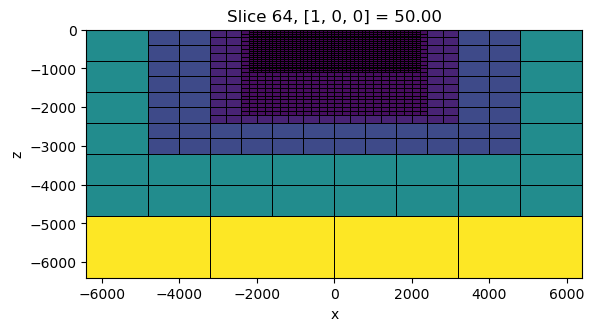

In [6]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes**(1/3), normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.show()

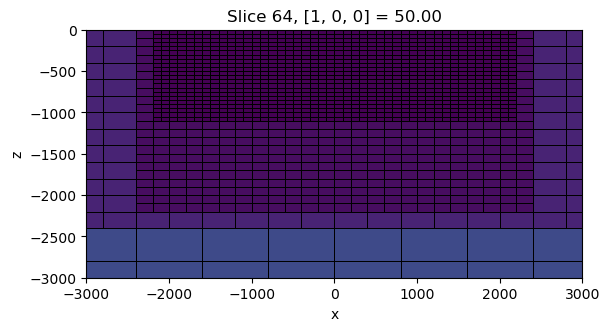

In [7]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes**(1/3), normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

## Build survey

In [8]:
receiver_locations = np.vstack(
    (df.easting, df.northing, df.upward)
).T
receiver_locations

array([[-2000., -2000.,    10.],
       [-1900., -2000.,    10.],
       [-1800., -2000.,    10.],
       ...,
       [ 1800.,  2000.,    10.],
       [ 1900.,  2000.,    10.],
       [ 2000.,  2000.,    10.]])

In [9]:
receivers = potential_fields.gravity.Point(
    receiver_locations,
    components="gz",
)

source = potential_fields.gravity.SourceField(
    receiver_list=[receivers],
)

survey = potential_fields.gravity.Survey(source)

## Build simulation

In [10]:
mapping = simpeg.maps.IdentityMap(mesh)
gravity_simulation = potential_fields.gravity.Simulation3DIntegral(
    mesh=mesh,
    survey=survey,
    rhoMap=mapping,
    engine="choclo",
)

## Build data object

In [11]:
# Define gravity data object
gravity_data = simpeg.Data(
    survey,
    dobs=df.gz.values,
    standard_deviation=df.gz_std.values,
)

## Build mapping for the mesh

In [12]:
model_map = simpeg.maps.IdentityMap(mesh)

## Define the data misfit

In [13]:
data_misfit = simpeg.data_misfit.L2DataMisfit(
    data=gravity_data, simulation=gravity_simulation
)
data_misfit

## Define sparse regularization

Create reference model

In [14]:
reference_model = np.zeros(mesh.n_cells)

Define depth weighting to use in the regularization

In [15]:
depth_weights = simpeg.utils.depth_weighting(
    mesh,
    receivers.locations,
    exponent=2.0,
)

Build the regularization

In [16]:
regularization = simpeg.regularization.Sparse(
    mesh,
    mapping=model_map,
    weights={"depth_weights": depth_weights},
    norms=[1, 2, 2, 2],
)

## Build the inversion

Define the optimization algorithm

In [17]:
optimization = simpeg.optimization.ProjectedGNCG(
    maxIter=50,    # max number of iterations
    lower=-1.0,    # bounds for the model parameters (in g/cc)
    upper=1.0,     # 
    maxIterCG=10,  # maximum number of iterations for the Conjugate Gradient
    tolCG=1e-3,    # tolerance for conj grad
)
optimization

Define inverse problem

In [18]:
inverse_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimization
)

Define directives

In [19]:
models_dir = Path(".") / "sparse-models"

In [20]:
# Define a starting value for the trade-off parameter (beta)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)

# IRLS
# (don't use IRLS if norms are all L2)
irls_iters = 0 if all(n == 2 for n in regularization.norms) else 30
update_IRLS = simpeg.directives.UpdateIRLS(
    cooling_factor=2.0,
    f_min_change=1e-4,
    max_irls_iterations=irls_iters,
    misfit_tolerance=1e-2,
)

# Update the preconditionner if it is model dependent
update_jacobi = simpeg.directives.UpdatePreconditioner()

# Save inversion parameters
save_params = simpeg.directives.SaveOutputEveryIteration(save_txt=False)

# Save model after each iteration
save_model = simpeg.directives.SaveModelEveryIteration(directory=str(models_dir))

In [21]:
# The directives are defined as a list.
directives = [
    update_IRLS,
    starting_beta,
    update_jacobi,
    save_params,
    save_model,
]

Define inversion

In [22]:
inversion = simpeg.inversion.BaseInversion(inverse_problem, directives)

### Run inversion

In [23]:
inverted_model = inversion.run(reference_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
simpeg.SaveModelEveryIteration will save your models as: 'sparse-models/###-InversionModel-2024-11-04-11-53.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.35e+01  8.51e+05  0.00e+00  8.51e+05    2.29e+02      0              
   1  2.17e+01  2.02e+05  3.19e+03  2.72

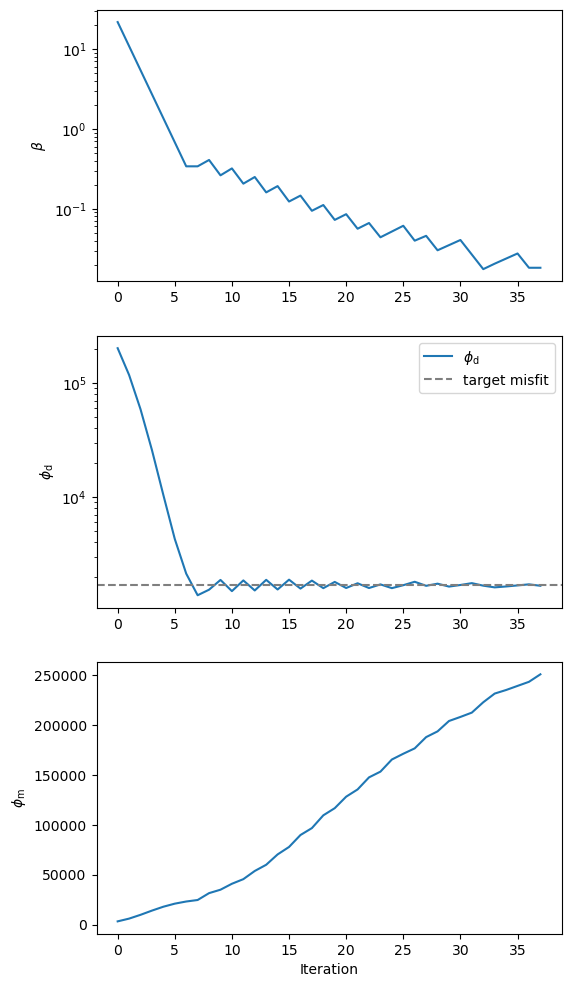

In [24]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

axes[0].plot(save_params.beta)
axes[0].set_yscale("log")
axes[0].set_ylabel(r"$\beta$")

axes[1].plot(save_params.phi_d, label=r"$\phi_\text{d}$")
axes[1].set_yscale("log")
axes[1].axhline(y=survey.nD, linestyle="--", color="C7", label="target misfit")
axes[1].legend()
axes[1].set_ylabel(r"$\phi_\text{d}$")

axes[2].plot(save_params.phi_m)
axes[2].set_ylabel(r"$\phi_\text{m}$")

axes[-1].set_xlabel("Iteration")
plt.show()

In [25]:
block_bounds = (-300, 300, -300, 300, -800, -500)

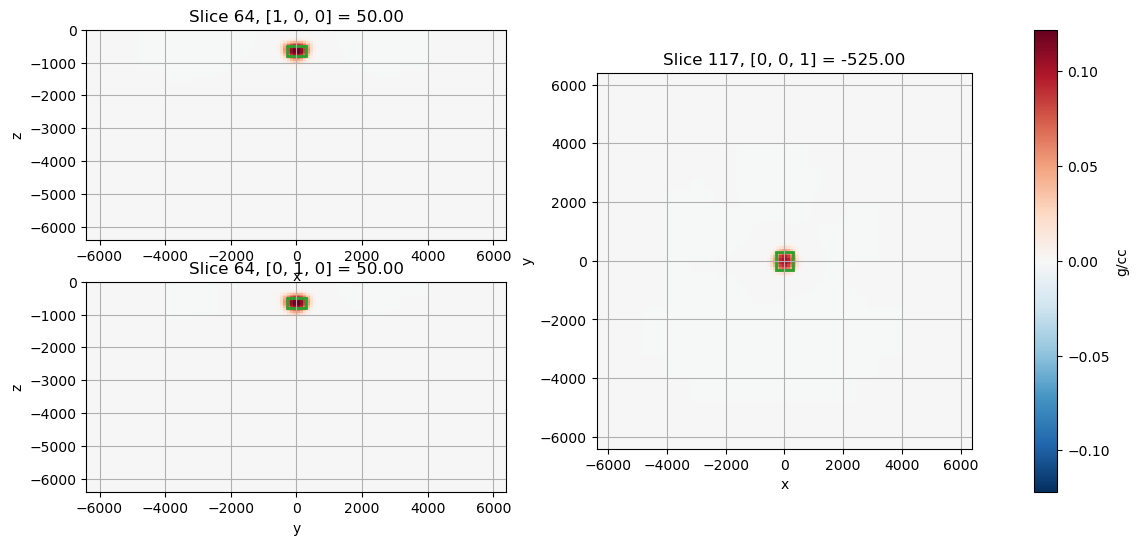

In [26]:
axes = plot_model(mesh, inverted_model)
plot_block(block_bounds, axes, linewidth=2)
plt.show()

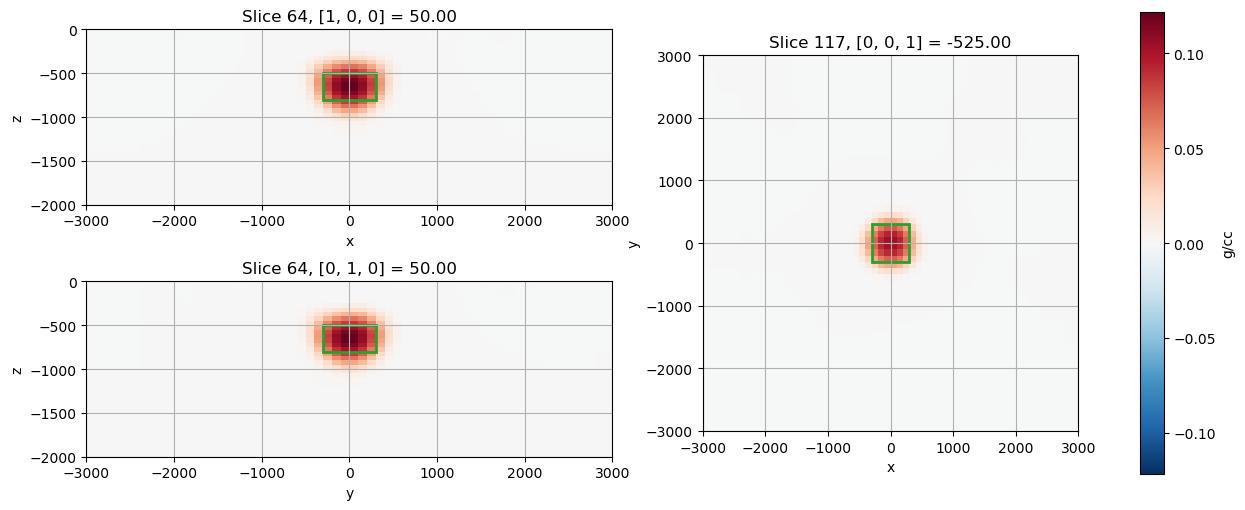

In [27]:
bounds = (-3e3, 3e3, -3e3, 3e3, -2e3, 0)
axes = plot_model(mesh, inverted_model, bounds=bounds)
plot_block(block_bounds, axes, linewidth=2)
plt.show()

## Check predicted data

In [28]:
gz_predicted = gravity_simulation.dpred(inverted_model)

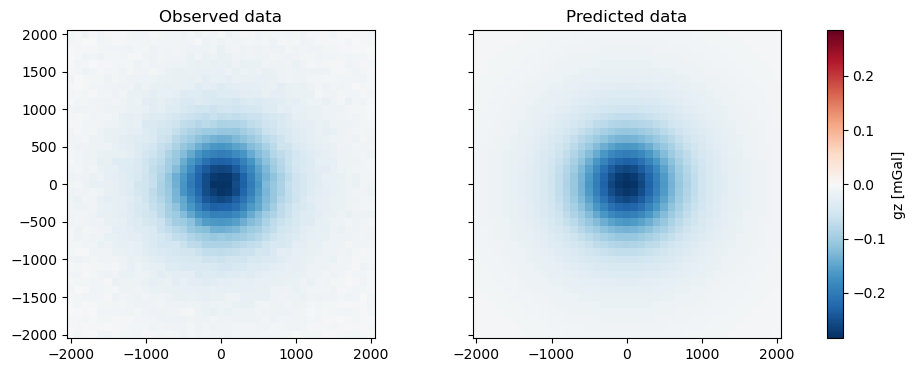

In [29]:
maxabs = max(np.max(np.abs(df.gz.values)), np.max(np.abs(gz_predicted))) 

easting = df.easting.values.reshape(shape)
northing = df.northing.values.reshape(shape)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(
    easting,
    northing,
    df.gz.values.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
ax2.pcolormesh(
    easting,
    northing,
    gz_predicted.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    
plt.colorbar(tmp, ax=(ax1, ax2), label="gz [mGal]")
ax1.set_title("Observed data")
ax2.set_title("Predicted data")

plt.show()

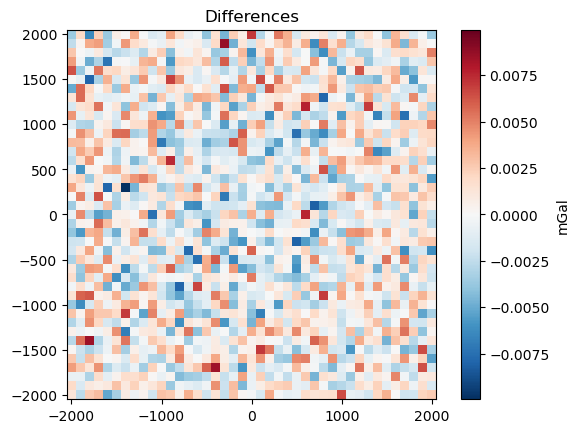

In [30]:
diff = df.gz.values - gz_predicted
maxabs = np.max(np.abs(diff))

plt.pcolormesh(
    easting,
    northing,
    diff.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="mGal")
plt.title("Differences")
plt.show()

## See al models

File: sparse-models/001-InversionModel-2024-11-04-11-53.npy


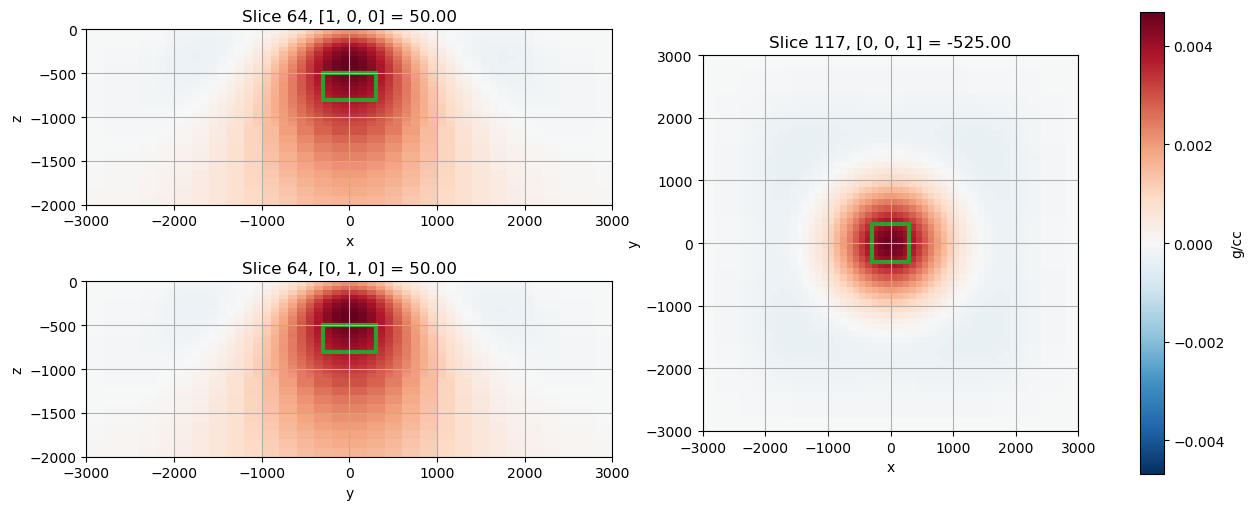

File: sparse-models/002-InversionModel-2024-11-04-11-53.npy


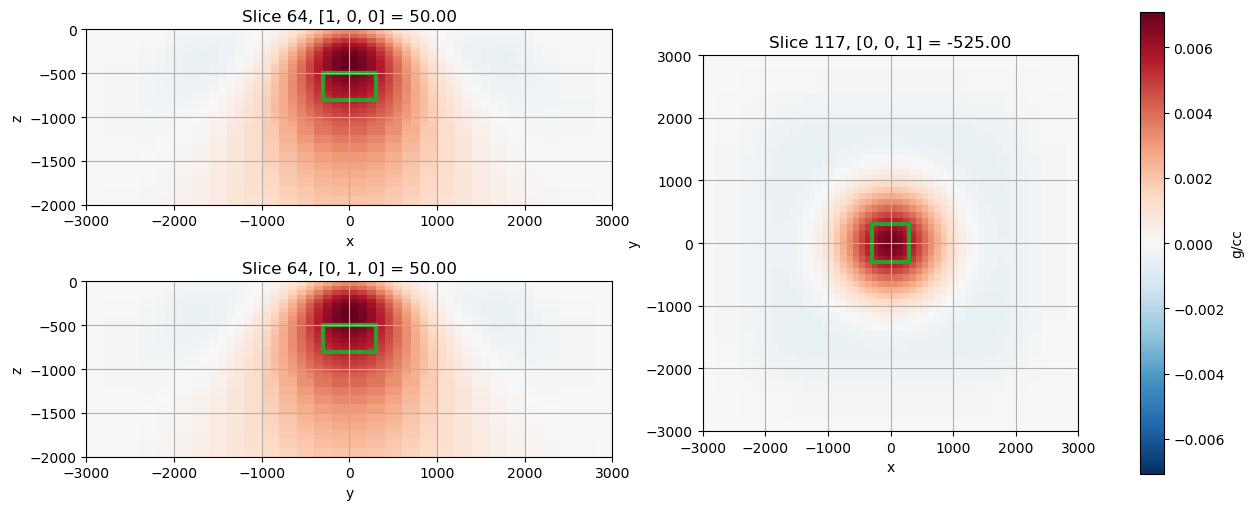

File: sparse-models/003-InversionModel-2024-11-04-11-53.npy


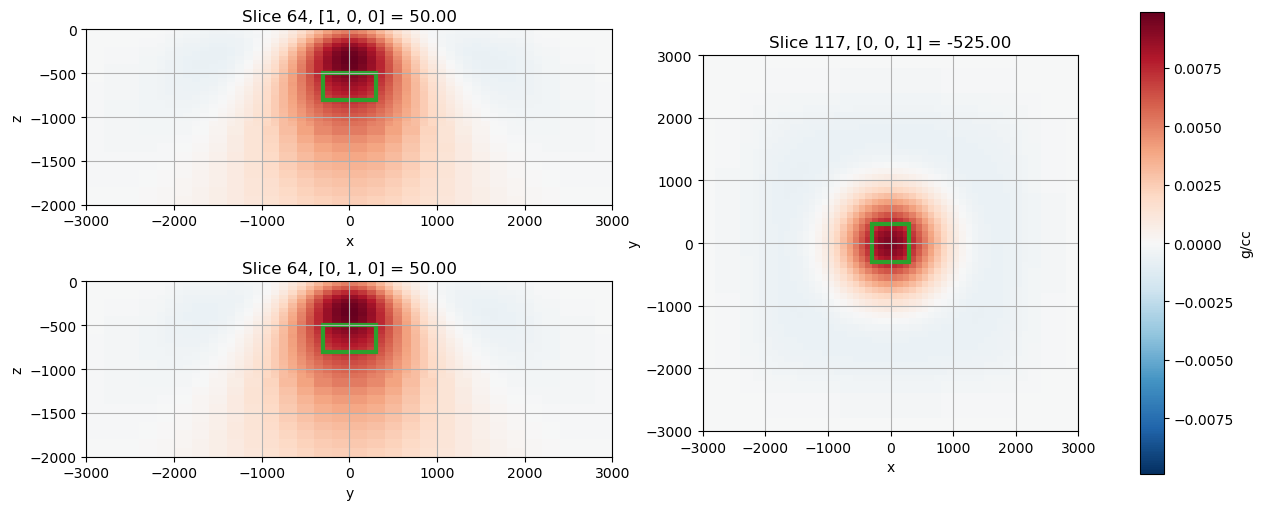

File: sparse-models/004-InversionModel-2024-11-04-11-53.npy


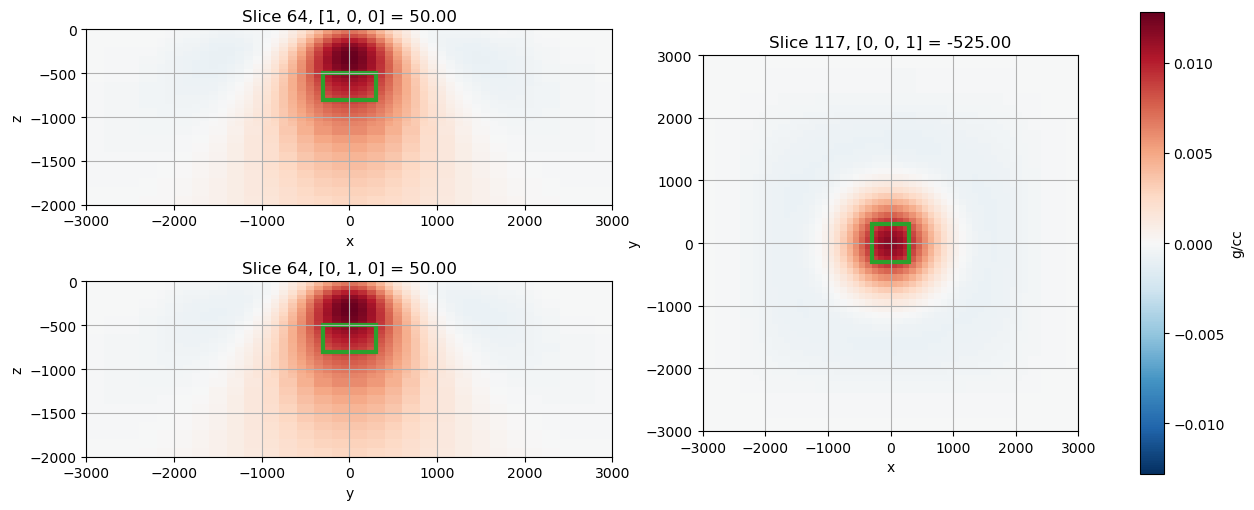

File: sparse-models/005-InversionModel-2024-11-04-11-53.npy


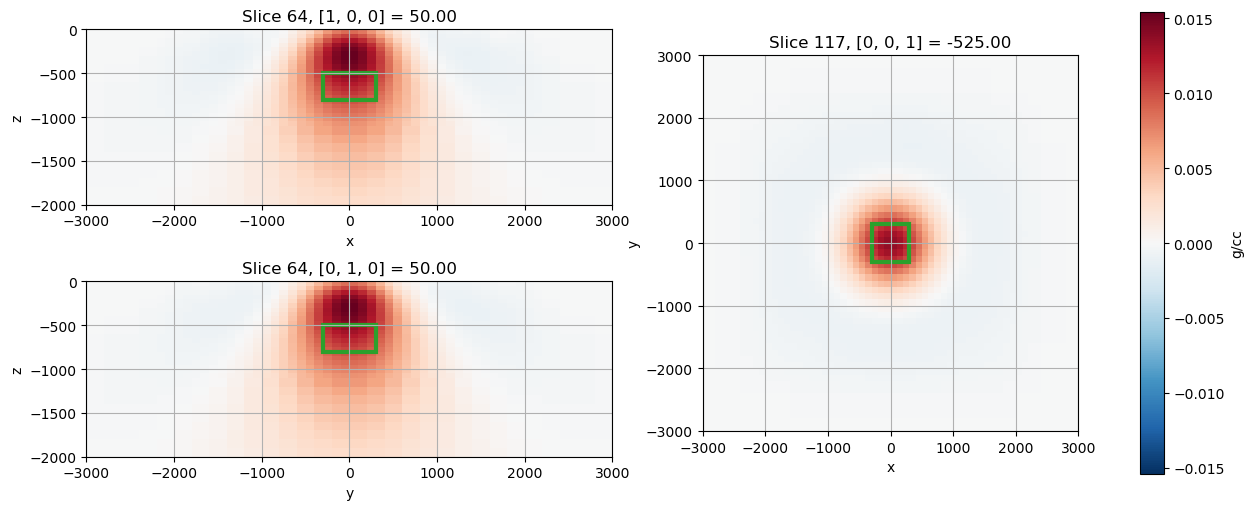

File: sparse-models/006-InversionModel-2024-11-04-11-53.npy


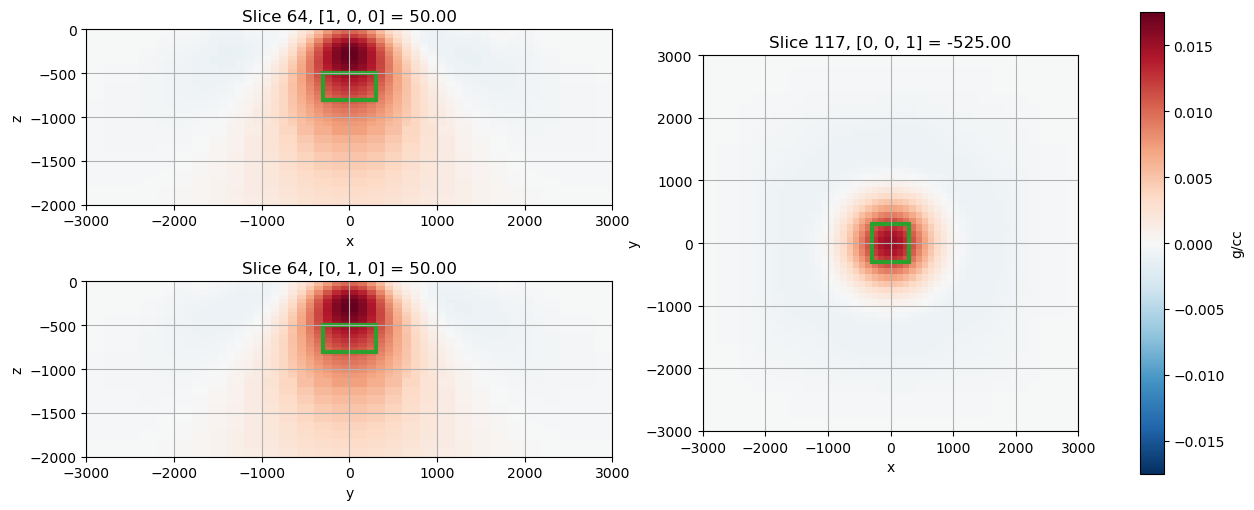

File: sparse-models/007-InversionModel-2024-11-04-11-53.npy


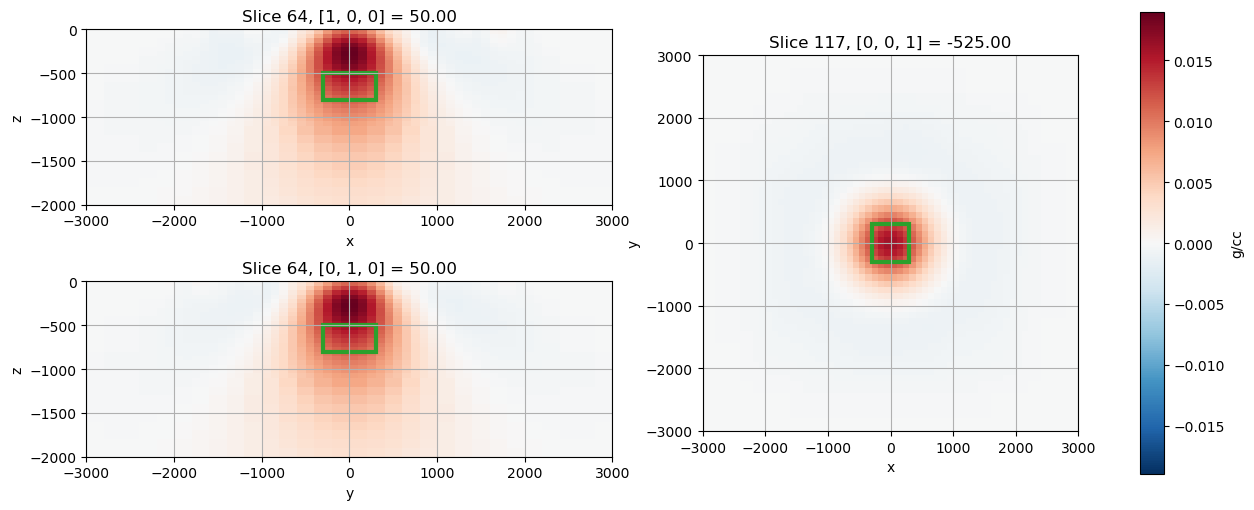

File: sparse-models/008-InversionModel-2024-11-04-11-53.npy


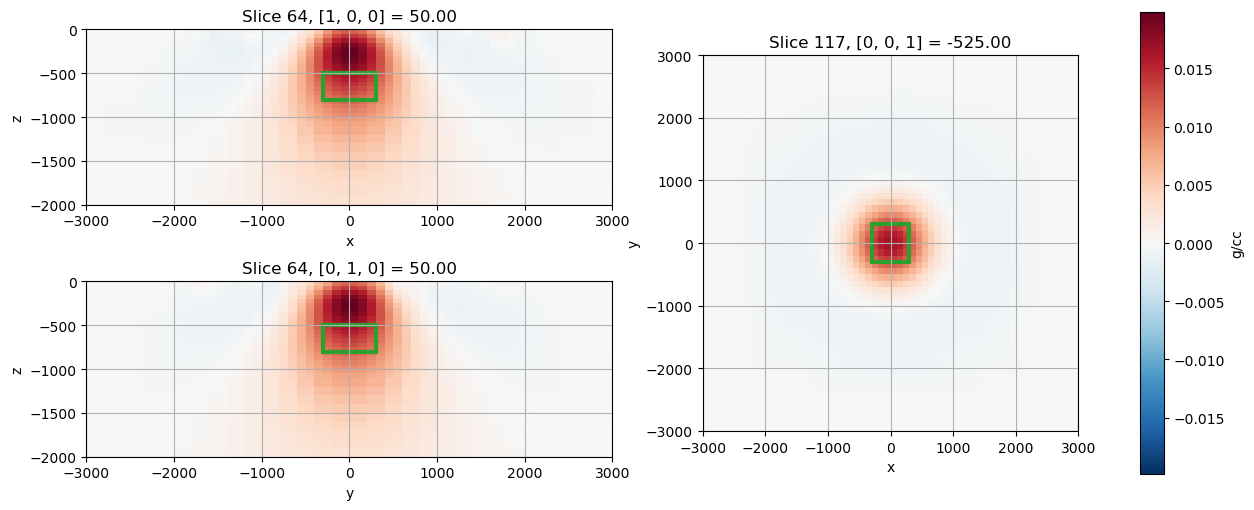

File: sparse-models/009-InversionModel-2024-11-04-11-53.npy


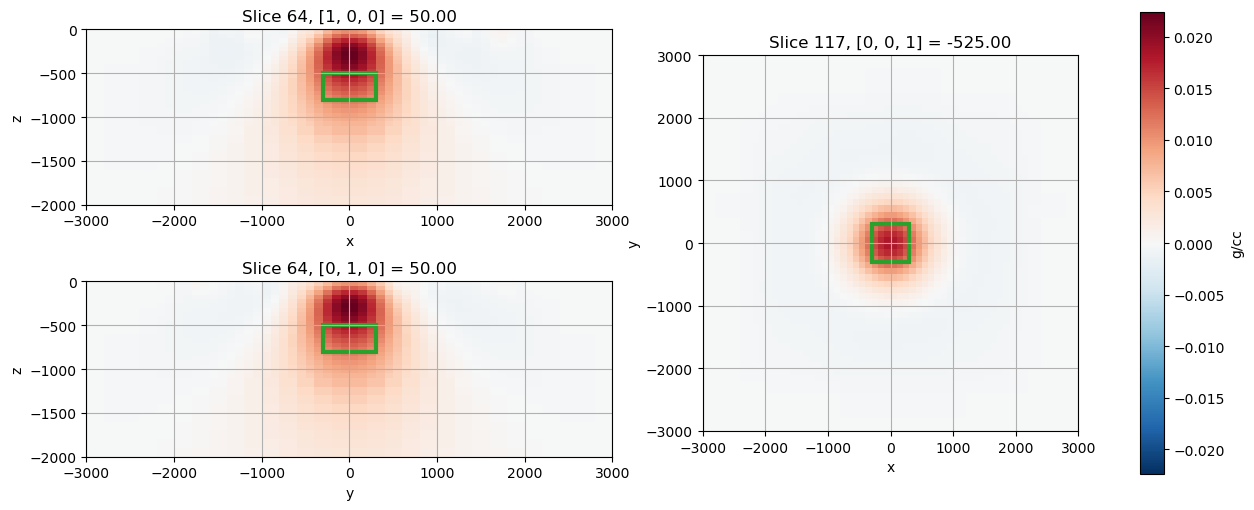

File: sparse-models/010-InversionModel-2024-11-04-11-53.npy


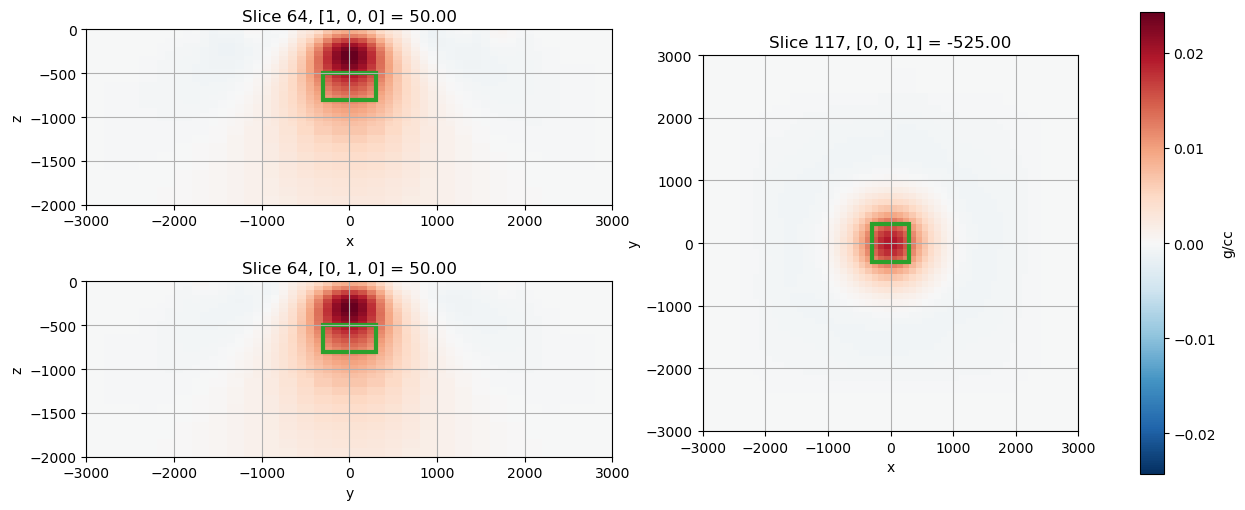

File: sparse-models/011-InversionModel-2024-11-04-11-53.npy


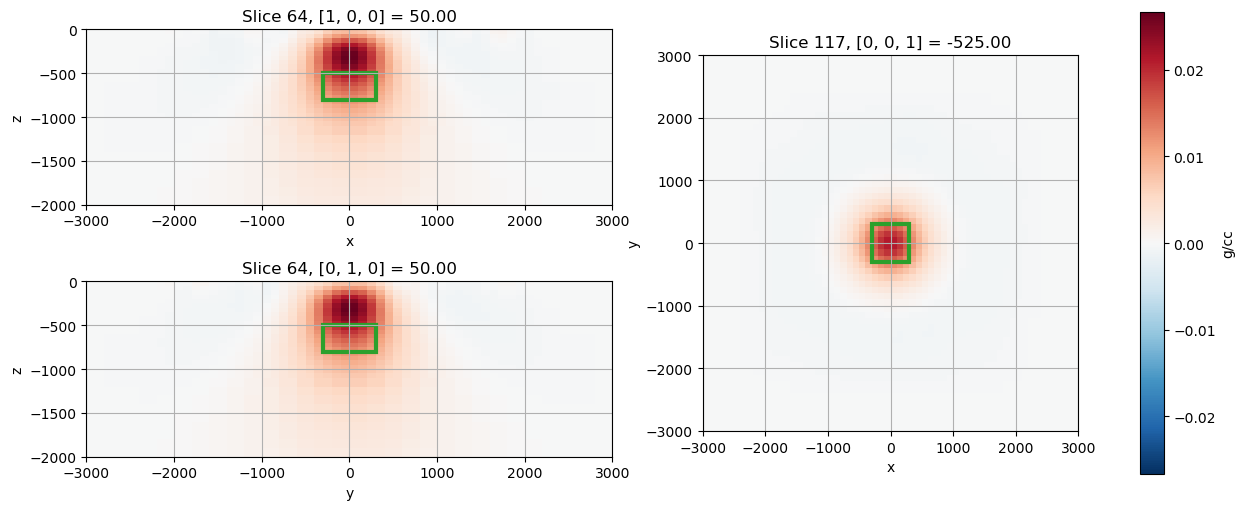

File: sparse-models/012-InversionModel-2024-11-04-11-53.npy


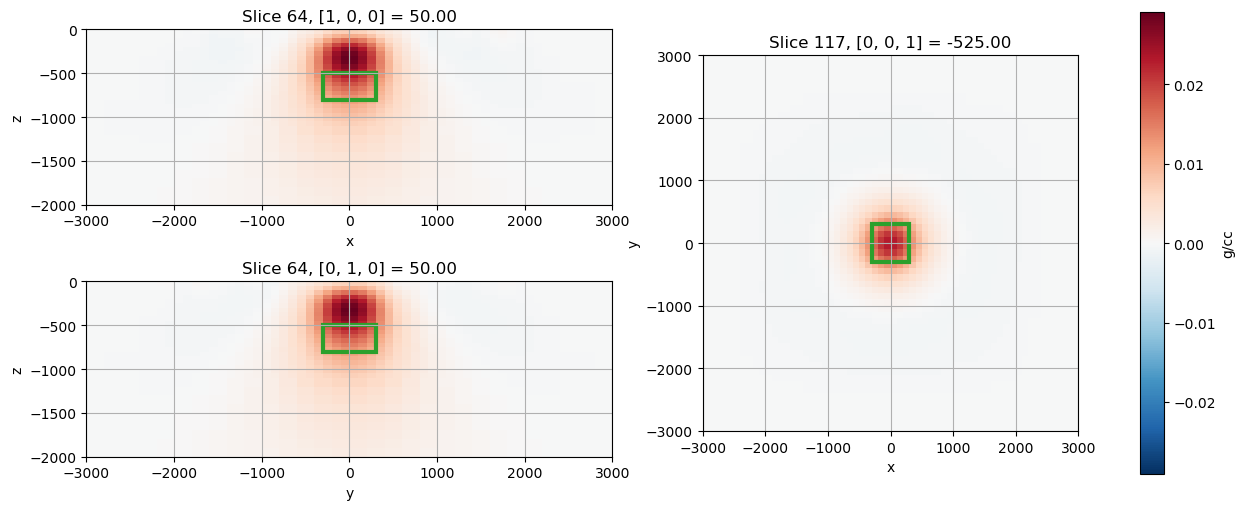

File: sparse-models/013-InversionModel-2024-11-04-11-53.npy


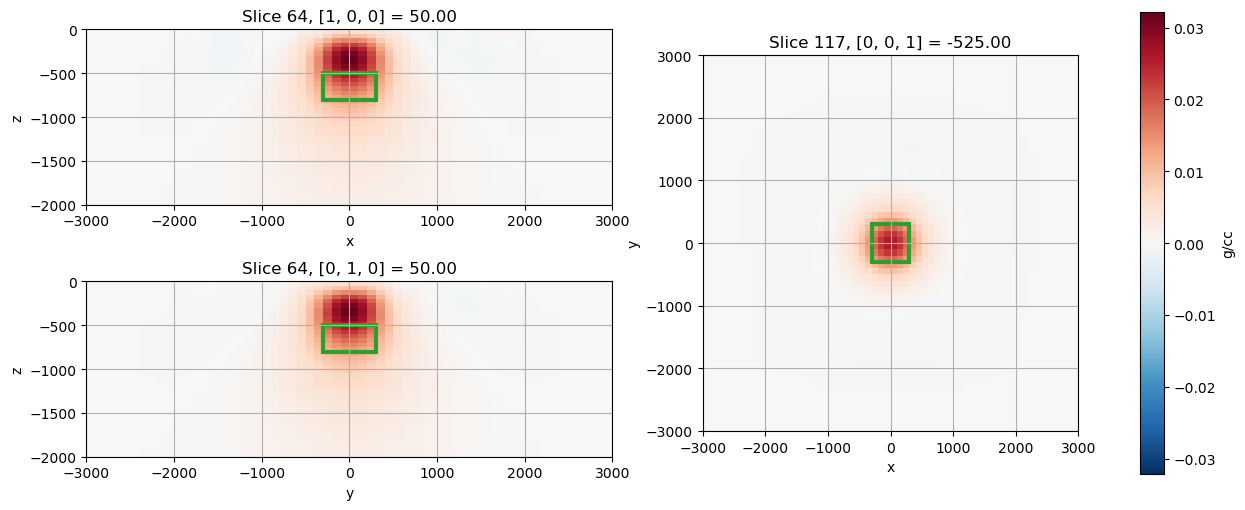

File: sparse-models/014-InversionModel-2024-11-04-11-53.npy


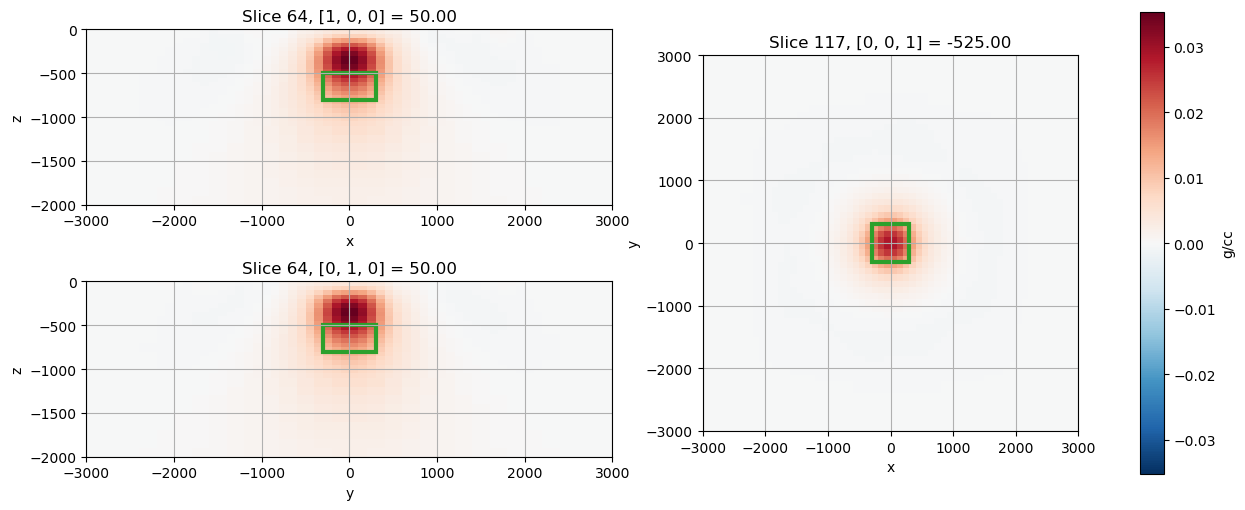

File: sparse-models/015-InversionModel-2024-11-04-11-53.npy


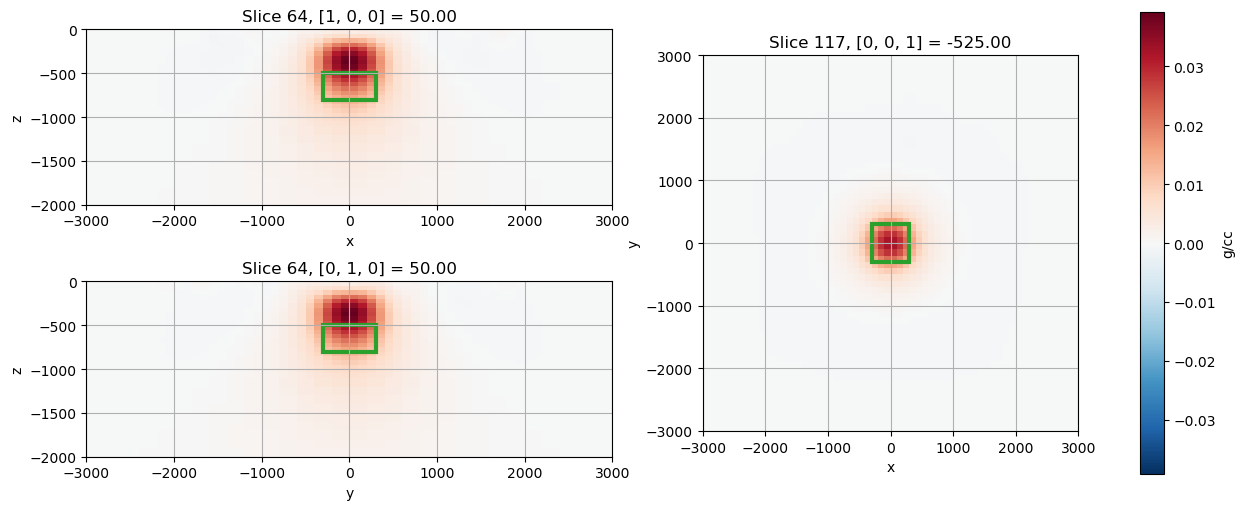

File: sparse-models/016-InversionModel-2024-11-04-11-53.npy


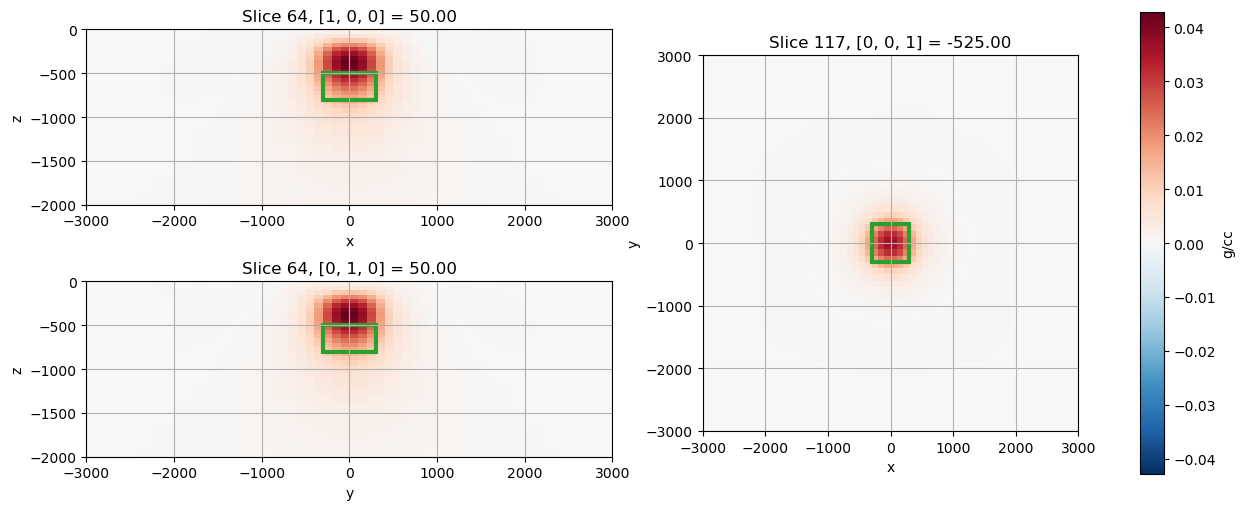

File: sparse-models/017-InversionModel-2024-11-04-11-53.npy


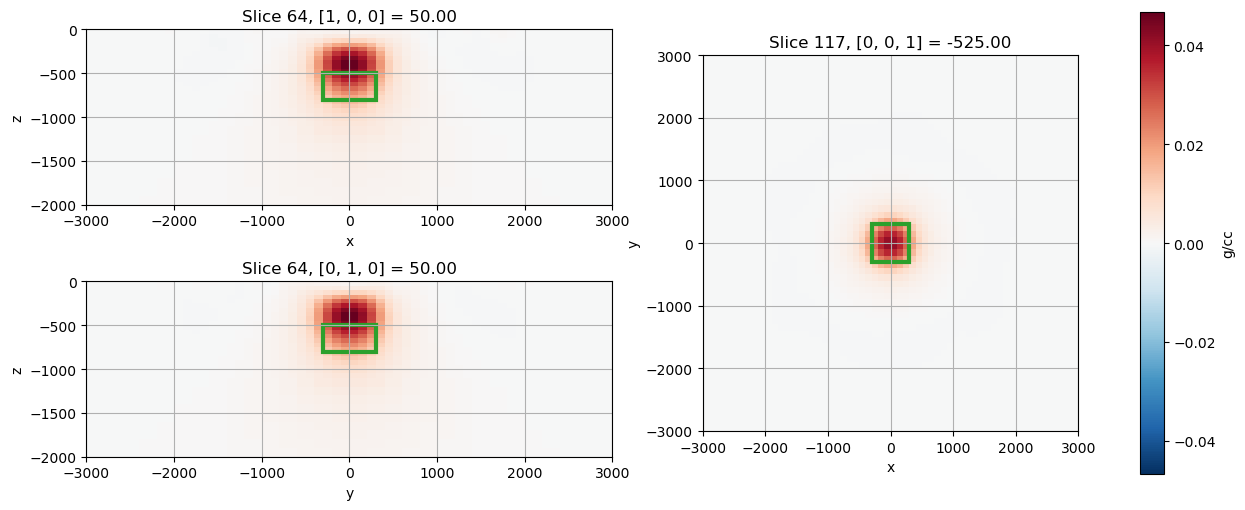

File: sparse-models/018-InversionModel-2024-11-04-11-53.npy


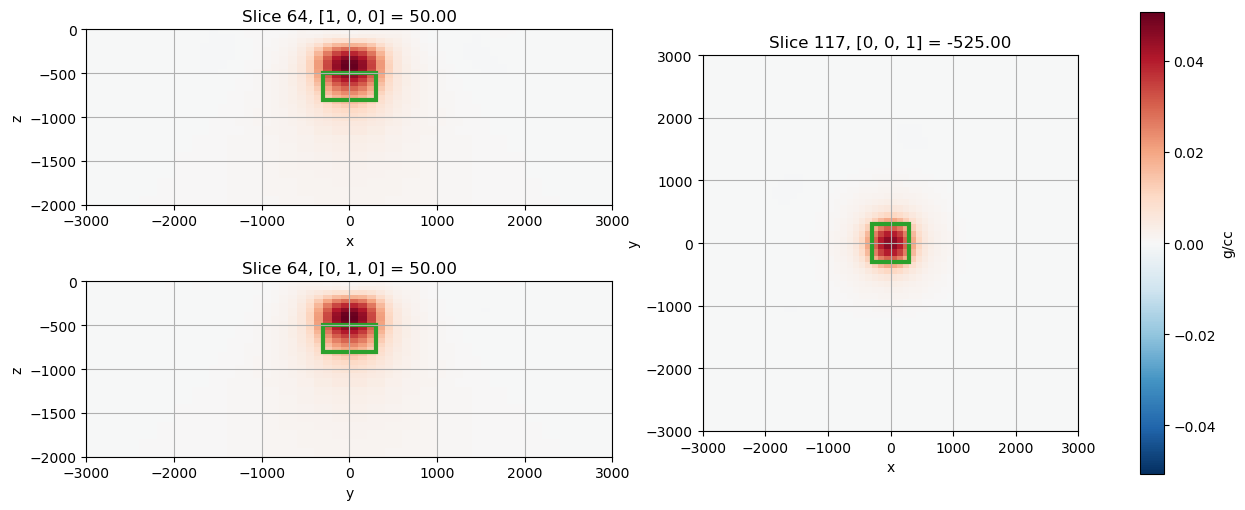

File: sparse-models/019-InversionModel-2024-11-04-11-53.npy


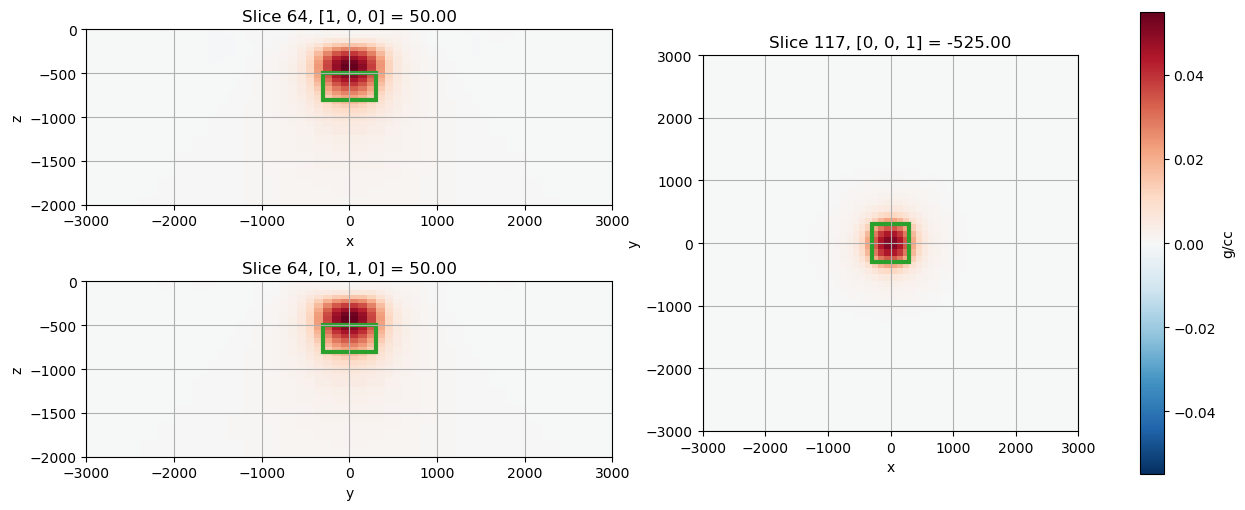

File: sparse-models/020-InversionModel-2024-11-04-11-53.npy


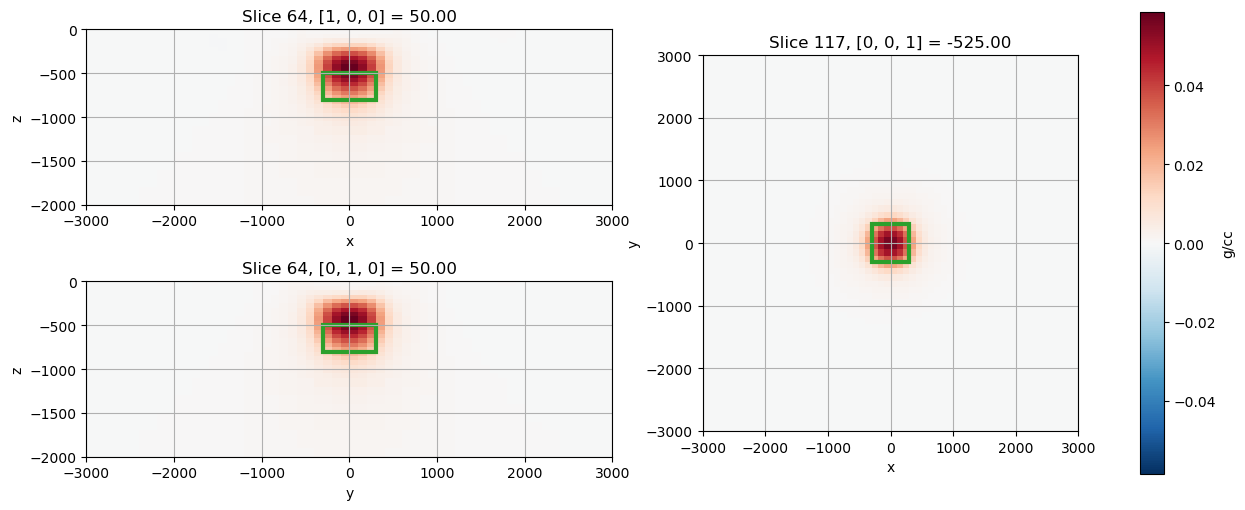

File: sparse-models/021-InversionModel-2024-11-04-11-53.npy


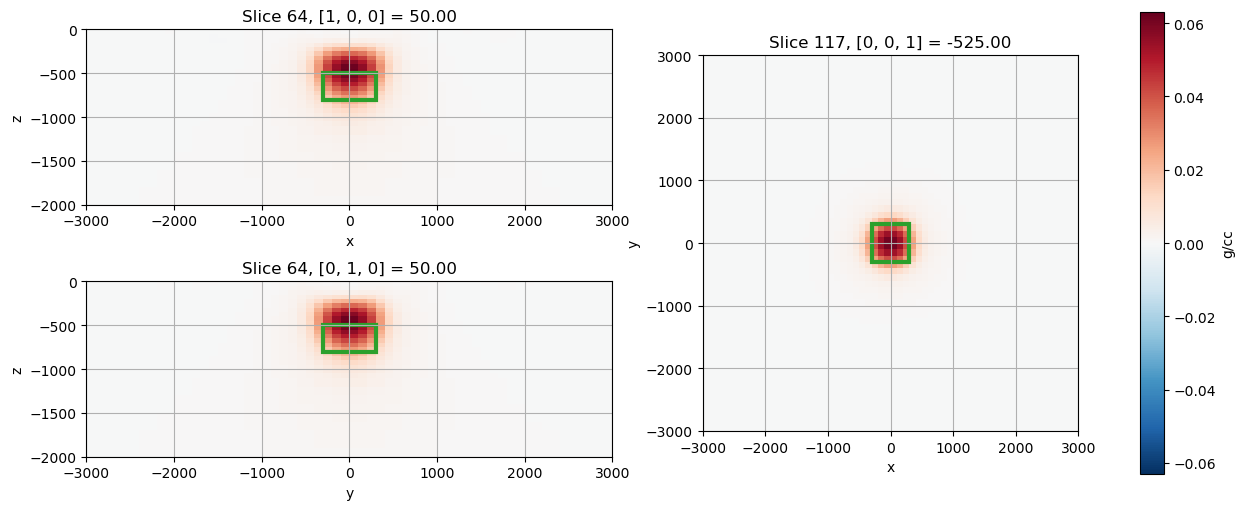

File: sparse-models/022-InversionModel-2024-11-04-11-53.npy


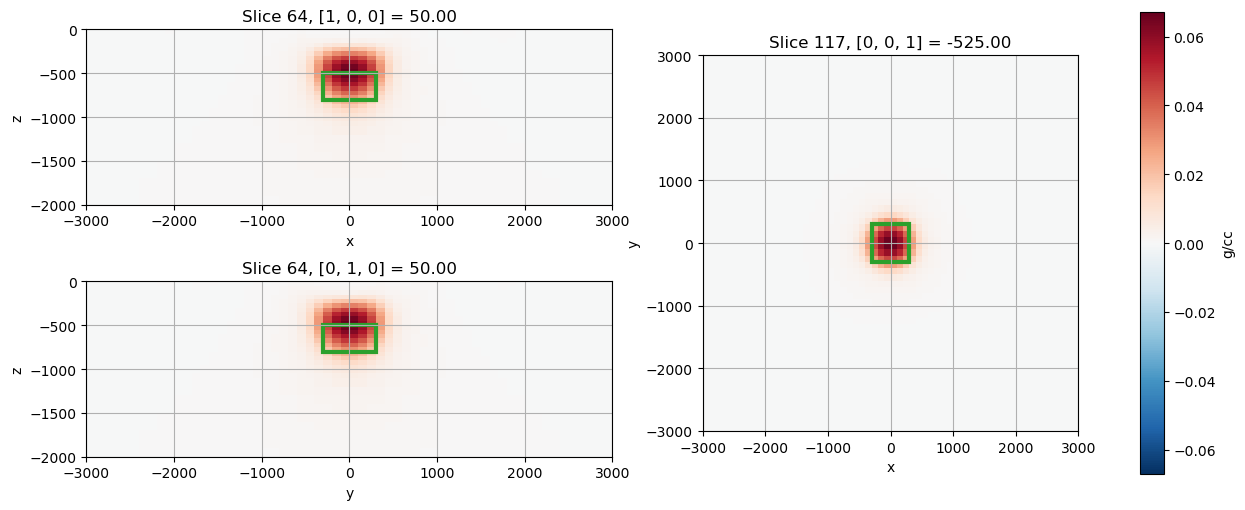

File: sparse-models/023-InversionModel-2024-11-04-11-53.npy


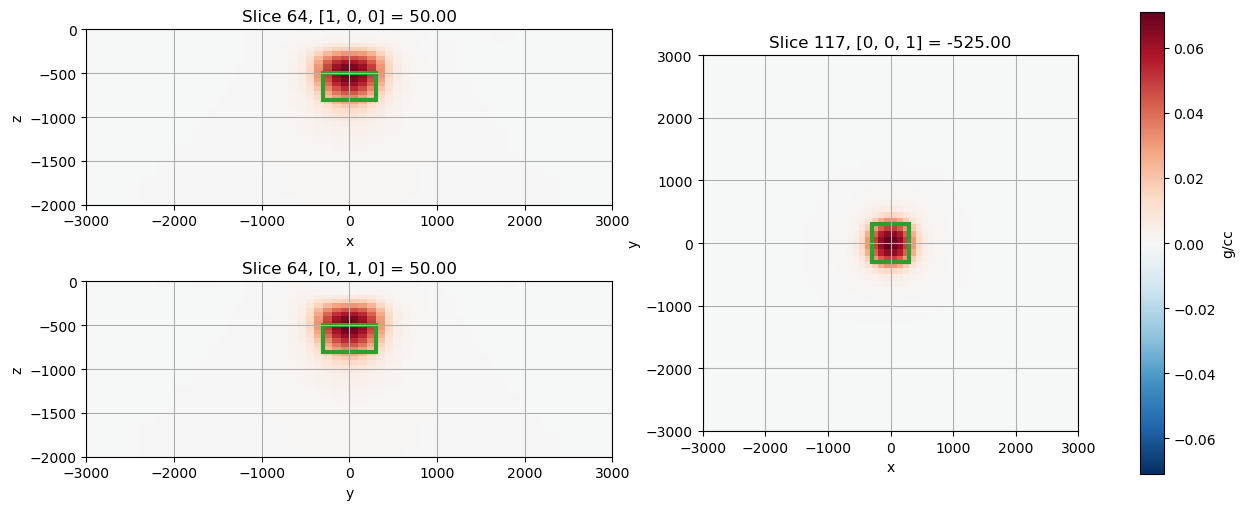

File: sparse-models/024-InversionModel-2024-11-04-11-53.npy


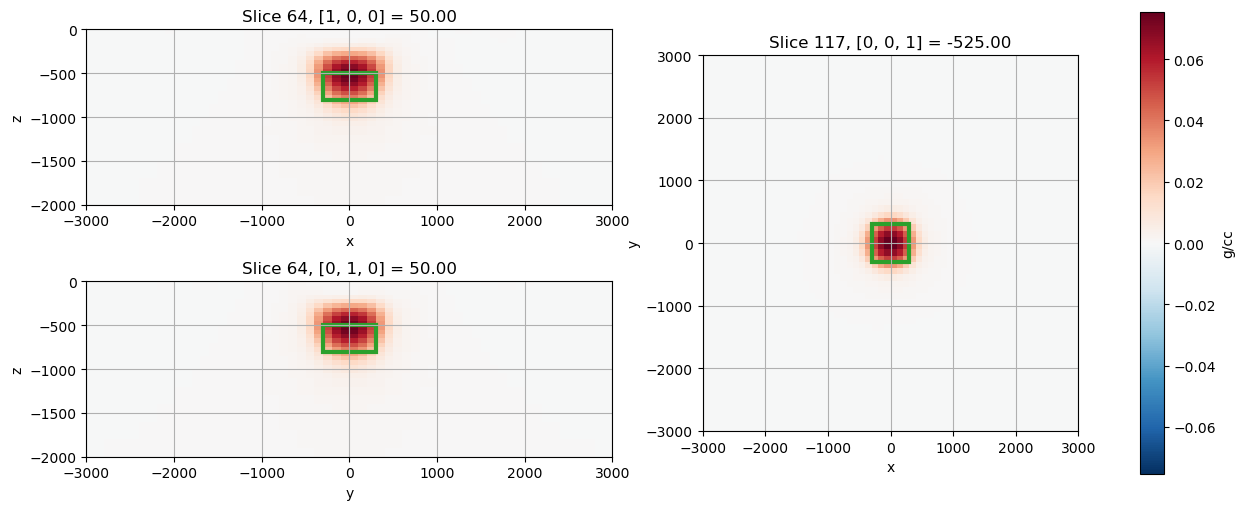

File: sparse-models/025-InversionModel-2024-11-04-11-53.npy


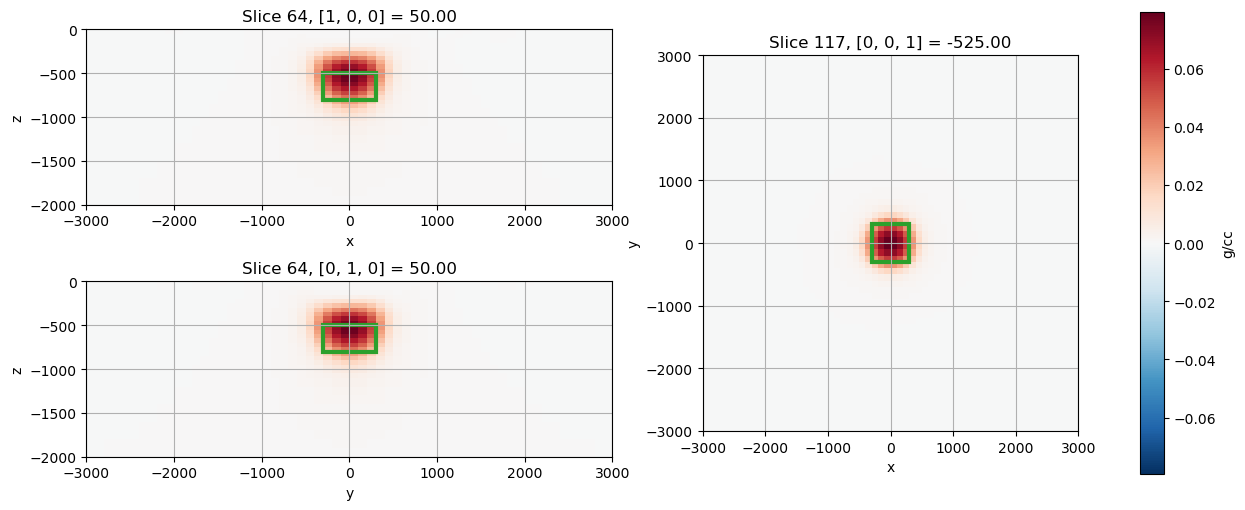

File: sparse-models/026-InversionModel-2024-11-04-11-53.npy


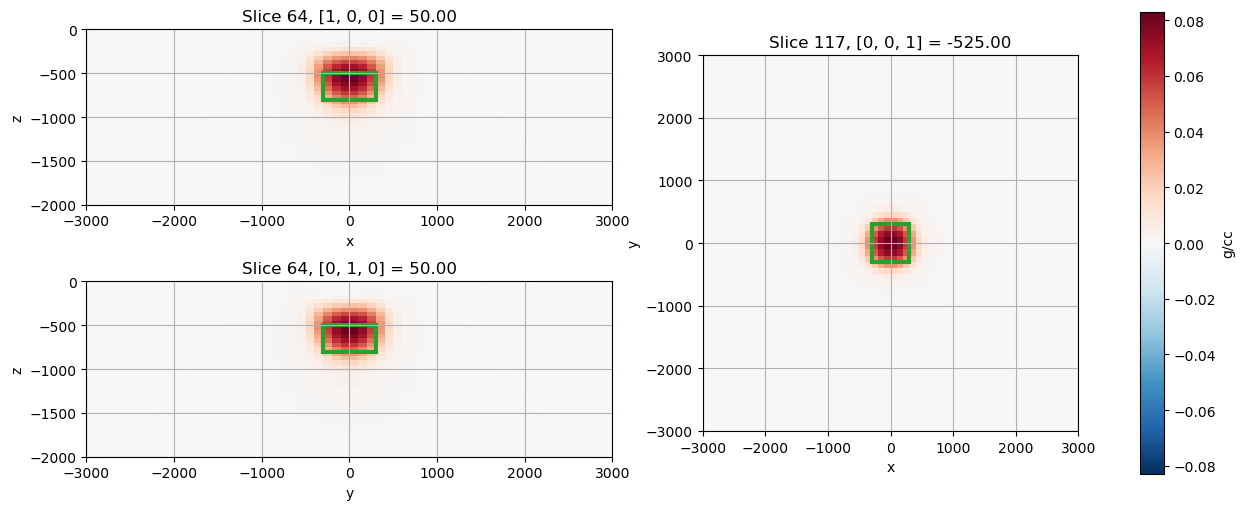

File: sparse-models/027-InversionModel-2024-11-04-11-53.npy


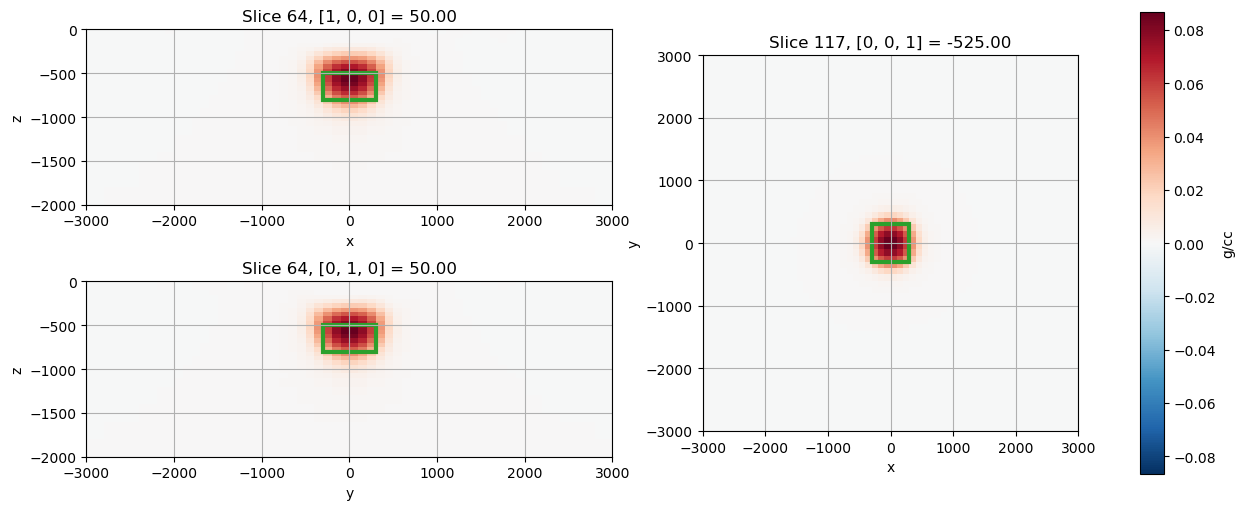

File: sparse-models/028-InversionModel-2024-11-04-11-53.npy


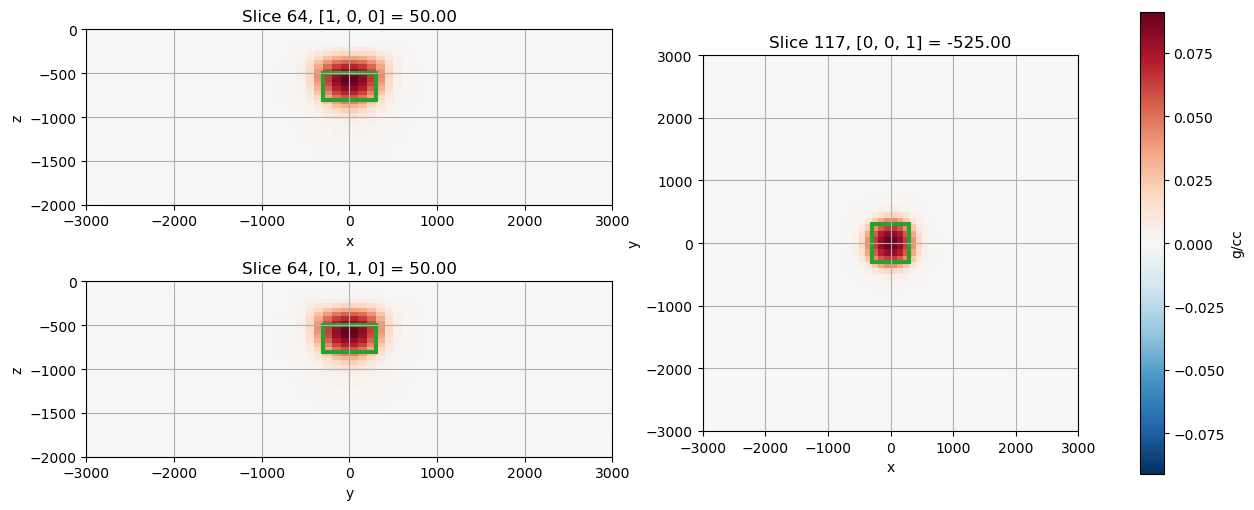

File: sparse-models/029-InversionModel-2024-11-04-11-53.npy


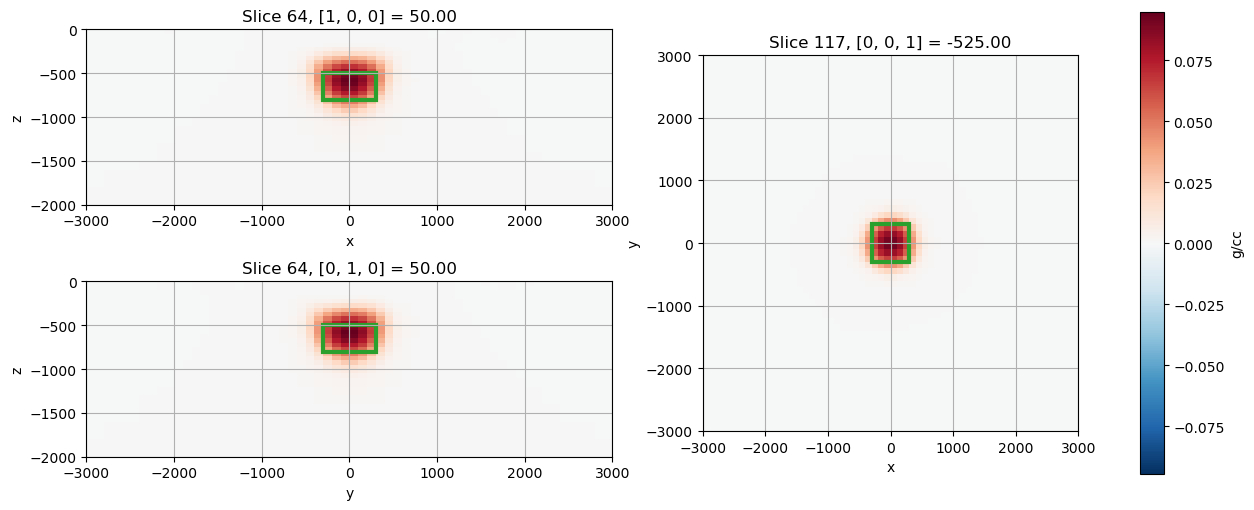

File: sparse-models/030-InversionModel-2024-11-04-11-53.npy


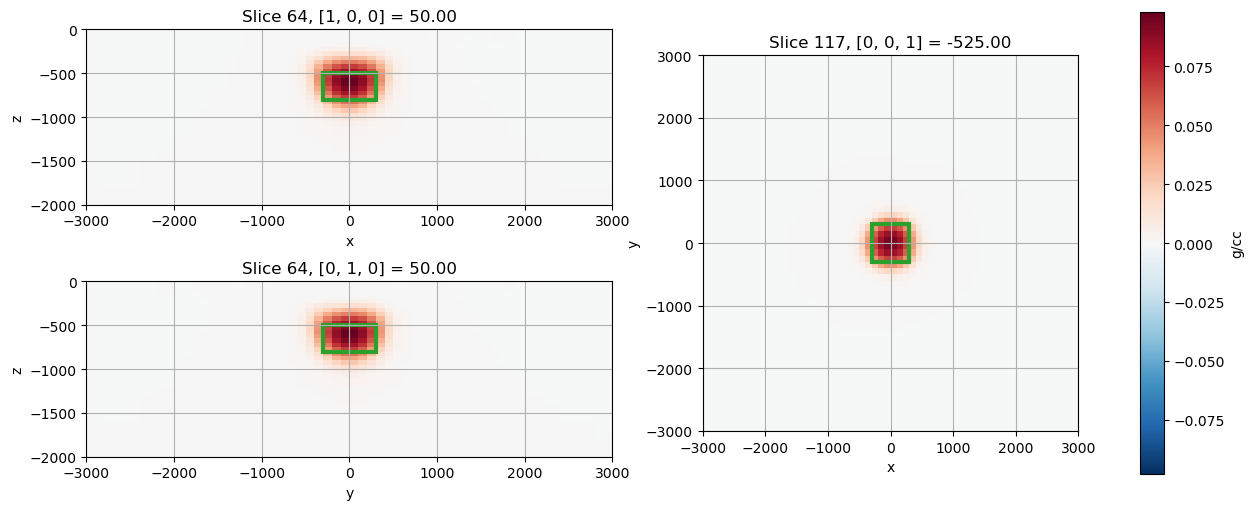

File: sparse-models/031-InversionModel-2024-11-04-11-53.npy


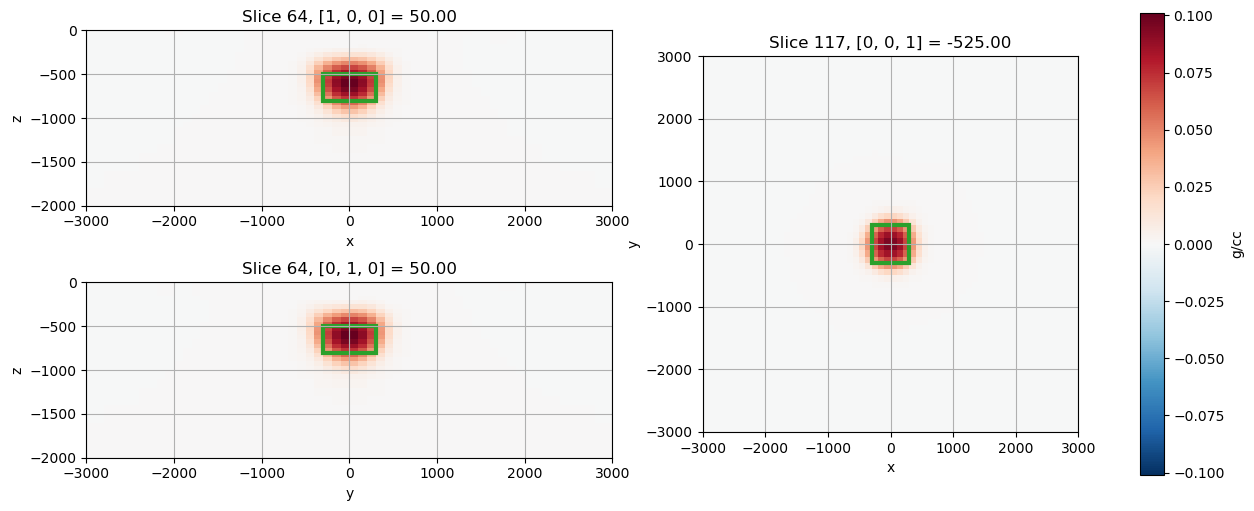

File: sparse-models/032-InversionModel-2024-11-04-11-53.npy


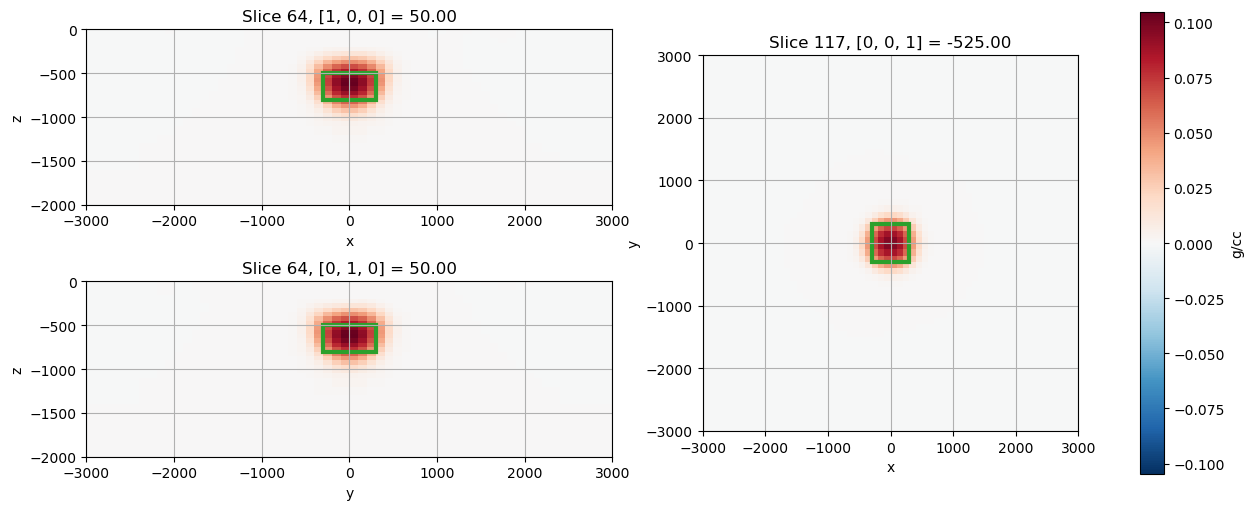

File: sparse-models/033-InversionModel-2024-11-04-11-53.npy


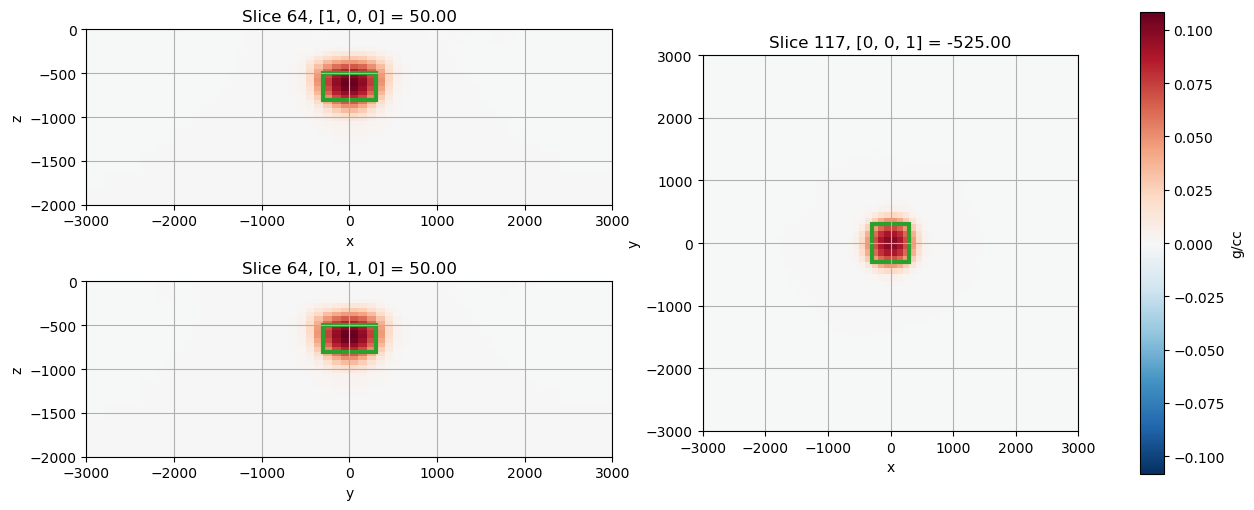

File: sparse-models/034-InversionModel-2024-11-04-11-53.npy


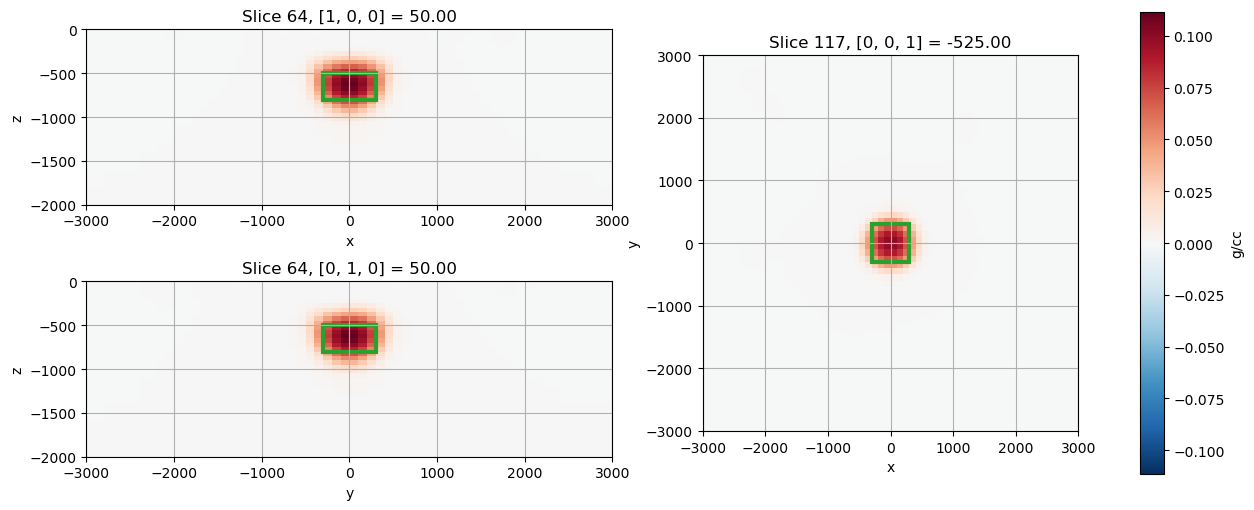

File: sparse-models/035-InversionModel-2024-11-04-11-53.npy


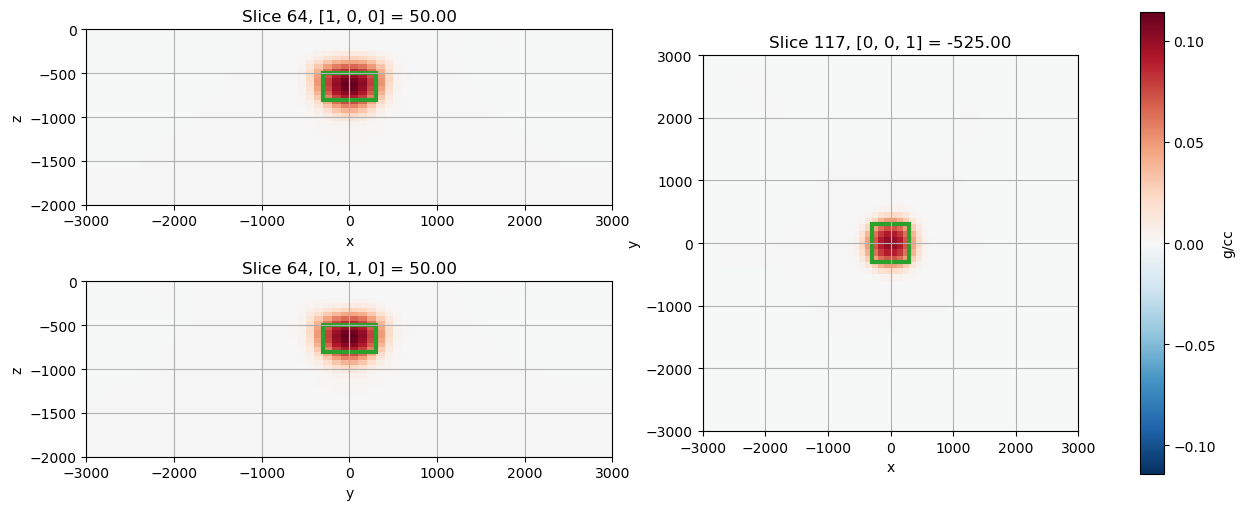

File: sparse-models/036-InversionModel-2024-11-04-11-53.npy


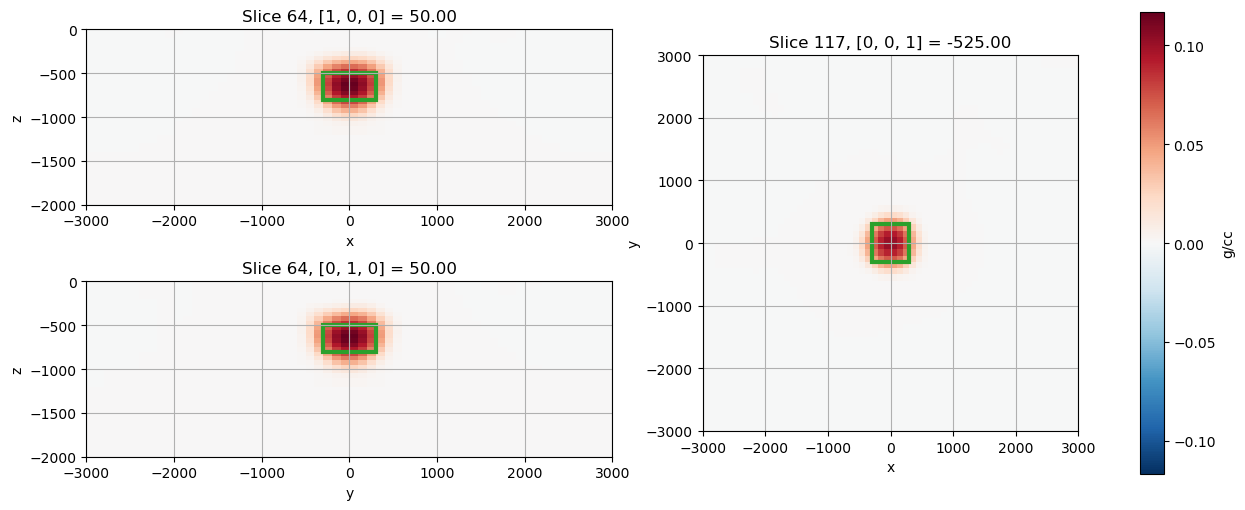

File: sparse-models/037-InversionModel-2024-11-04-11-53.npy


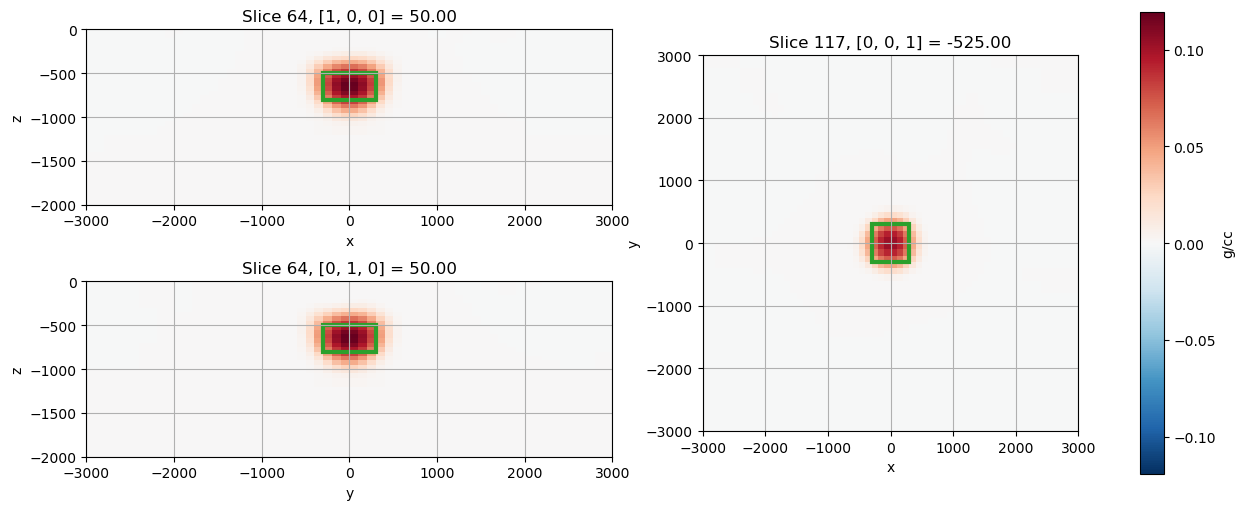

File: sparse-models/038-InversionModel-2024-11-04-11-53.npy


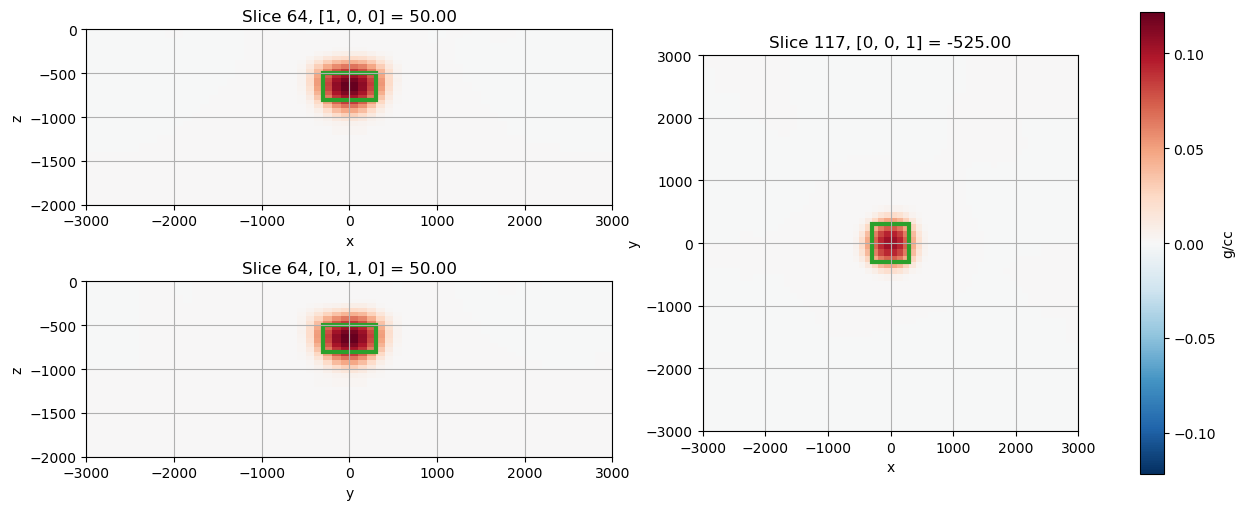

In [31]:
bounds = (-3e3, 3e3, -3e3, 3e3, -2e3, 0)

files = get_latest_model_files(save_model.directory)
for file in files:
    print(f"File: {file}")
    model_iter = np.load(file)
    axes = plot_model(mesh, model_iter, bounds=bounds)
    plot_block(block_bounds, axes)
    plt.show()